# 情報活用講座：　ケモインフォマテックス 編　
# 第5回：　スクリーニング


## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第９章第３節　プロジェクトの例/ 解析例２：水溶解度データと構造生成

## 目標
第４回では10,000の仮想化合物のバーチャルライブラリを作成しました。本編では、これらの化合物から候補材料を見つけます。以下の４つを念頭に進めます。

* 教師データから適用範囲（AD）を定めます。ここではT2指標、Q値という距離指標を用います。
* 第４回で構造生成した仮想ライブラリを予測器にかけ、適用範囲（AD）内に収まる化合物をスクリーニングします。

## データセット
delaney-processed.csvは1128化合物の水溶解度についてのデータセットです。このデータセットは、Delaneyの論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] で発表されたものに基づいています。

[1] John S. Delaney, "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure", J. Chem. Inf. Comput. Sci. 44, 1000–1005 (2004) (DOI: 10.1021/ci034243x)  

Delaney-processed.csvは、分子の化学式、SMILES表記、また、水溶解度としてオクタノール水分配係数が含まれており、これらの特性は薬物探索や環境影響評価などの目的で使用されています。

1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度（オクタノール水分配係数）の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!git clone https://github.com/ARIM-Academy/Advanced_Tutorial_4.git

%cd Advanced_Tutorial_4

## 1.分子構造データの読み込み （P.130）
### ライブラリのインポート

In [1]:
#データ構造化ライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

#機械学習ライブラリ
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics


#記述子ライブラリ
from rdkit import Chem
from rdkit.Chem.AllChem import GetHashedMorganFingerprint

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

### サンプルファイルの読み込み
第一回と同じく「data/delaney-solubility」フォルダーにあるdelaney-processed.csvをpandasの`read_csv()`で読み込みます。RDKitの`MolFromSmiles`関数を[smiles]列に適用してmol構造への変換オブジェクトを[mol]列とする流れも第一回と同じです。

In [2]:
df=pd.read_csv('./data/dataset/delaney-processed.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x000001F44E8...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x000001F44E8...
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x000001F44E8...
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x000001F44E8...
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x000001F44E8...
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x000001F44E9...
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x000001F44E9...
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x000001F44E9...
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x000001F44E9...


### データセットの分割（Data set splitting）
分割は`test_size=0.2`として訓練データ：0.8、テストデータ：0.2とします。

In [3]:
df_train, df_test = train_test_split(df, 
                                     test_size=.20, 
                                     random_state=42)

目的変数を'measured log solubility in mols per litre'にセットします。

In [4]:
ytrain = df_train['measured log solubility in mols per litre']

In [5]:
from cheminfo.descriptors import RDKitDescriptor
rdcalc = RDKitDescriptor()

X = rdcalc.fit_transform(df_train['mol'])
Xtrain = np.array(X.tolist())

#X2 = rdcalc.transform(df_test['mol'])
#Xtest = np.array(X2.tolist())

### 機械学習モデル

In [7]:
params = {'n_components': np.arange(1, 16)}
optim = GridSearchCV(PLSRegression(), params)

In [8]:
optim.fit(Xtrain, ytrain)

GridSearchCV(estimator=PLSRegression(),
             param_grid={'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

In [9]:
#ycalc = optim.predict(Xtrain)
#ypred = optim.predict(Xtest)

## 3.適用範囲（AD）の設定
第６回で作成した10,000の仮想化合物にたいして、上記のRDKit記述子をベースとしたPLSモデルによる予測を行います。また、予測結果が信頼できるかを確認するため、底本ではT2指標、Q値から適用範囲を定めています。 


【補足】  
T2指標とQ値は、生産における品質管理に関連する統計的な手法です。主に多変量データを分析し、プロセスの安定性や品質の変化を監視するために使用されます。

1. **T2指標 (T2 Statistic)**:
T2指標は、多変量プロセス監視のための統計的な指標で、プロセス内の変動や異常を検出するのに役立ちます。基本的には、多変量データの平均値と分散の組み合わせを用いて計算されます。T2指標はホットリリースティック法（HOTELLING'S T2法）に基づいています。

T2指標は、以下の手順で計算されます：
1. データセットの平均ベクトル（多変量データの平均値）を計算します。
2. データセットの共分散行列（多変量データの分散共分散行列）を計算します。
3. プロセスから得られたデータの平均ベクトルを計算し、それを基準平均ベクトルと比較します。
4. プロセスから得られたデータの共分散行列を計算し、それを基準共分散行列と比較します。

T2は距離指標であり、その測長には**マハラノビス距離**を用いています。これよりT2値（マハラノビス距離）を計算し、特定の閾値と比較することで、プロセスの異常や変化を監視することができます。

2. **Q値 (Q Statistic)**:
Q値も多変量プロセス監視のための指標で、プロセス内の変動や異常を検出する際に使用されます。T2指標と同様に、Q値も異常を検出するための基準となる閾値と比較されます。

Q値は、データの観測値が平均値からどれだけ離れているかを示す指標で、基本的にはT2指標の計算における差異ベクトルを用いて計算されます。Q値は、各観測値の差異ベクトルの長さを示し、この長さが閾値を超える場合に異常と判定されることがあります。

なお、T2指標、Q値は関数は次のようにdef関数として使います。PLSに対してT2指標、Q値を適用した内容については下記の技術ブログも参照してください。  
https://nirpyresearch.com/outliers-detection-pls-regression-nir-spectroscopy-python/

In [10]:
def t2_score(data, model):
    "T2値の計算モジュール"
    assert type(data)==pd.DataFrame or type(data)==np.ndarray, "input must be pandas.DataFrame or np.array"
    
    explained_std_ = np.sqrt(model.best_estimator_.x_scores_.var(axis=0))
    scores_whiten = model.transform(data) / explained_std_
    
    return (scores_whiten ** 2.). sum(axis=1)

def q_value(data, model):
    "Q値の計算モジュール"
    assert type(data)==pd.DataFrame or type(data)==np.ndarray, "input must be pandas.DataFrame or np.array"
    
    x_reproduced_ = model.transform(data) @ model.best_estimator_.x_loadings_.T
    
    return ((data - x_reproduced_)**2.).sum(axis=1)

### 適用範囲（AD）の設定
ADの設定範囲はdelaneyの溶解度データの教師データよりt2指標および q値を計算し、その範囲を定めます。Xtrainデータ（教師データ）よりT2指標とQ値を計算し、その95%quantile（２σ）を適用範囲の上限として設定します。

### T2指標およびQ値の計算

In [11]:
t2_values = t2_score(Xtrain, optim)
q_values = q_value(Xtrain, optim)

In [12]:
#t2_values

### ADの上限値設定
ここではT2指標およびQ値の95%quantile（２σ）を適用範囲の上限として設定しています。

In [13]:
t2_95q = np.quantile(t2_values, 0.95)
qval_95q = np.quantile(q_values, 0.95)

print('t^2 - 95% quantile', t2_95q, '\nq value - 95% quantile', qval_95q)

t^2 - 95% quantile 30.847121386233002 
q value - 95% quantile 512214902355.4178


### ADの可視化
設定されたADの範囲をプロットします。横軸をT2指標、縦軸をQ値とし、それぞれの95% quantileを破線で表示します。

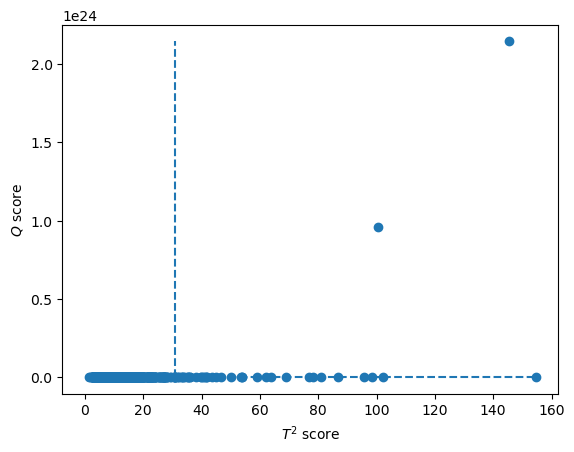

In [14]:
plt.plot(t2_values, q_values, 'o')

plt.xlabel('$T^2$ score')
plt.ylabel('$Q$ score')
plt.vlines(t2_95q, ymin=0, ymax=q_values.max(), linestyles='--')
plt.hlines(qval_95q, xmin=0, xmax=t2_values.max(), linestyles='--')

plt.show()

ADの範囲がわかるように軸設定を変更します。

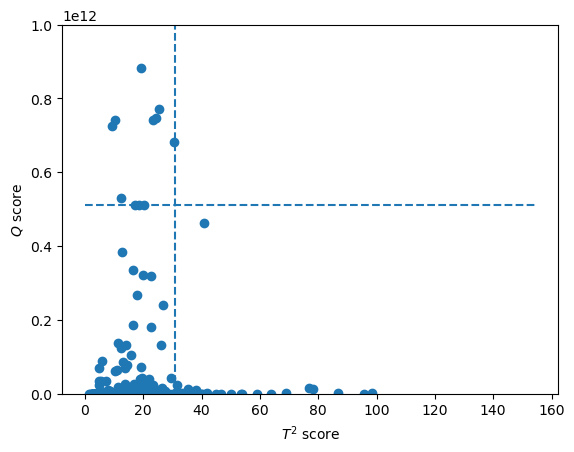

In [15]:
plt.plot(t2_values, q_values, 'o')

plt.xlabel('$T^2$ score')
plt.ylabel('$Q$ score')

plt.ylim(-1e9,1e12)
plt.vlines(t2_95q, ymin=0, ymax=q_values.max(), linestyles='--')
plt.hlines(qval_95q, xmin=0, xmax=t2_values.max(), linestyles='--')

plt.show()

## 4.スクリーニング
第６回で生成した10万の仮想化合物について並列処理によるPLSの予測器にかけて演算します。演算結果をSMILES構造（smi）、溶解度の予測値（ypred）, 当該予測値のt2指標（t2）および q値（q）の4つを.outファイルとして出力します。

### 下記は【Google Colab】のみで実行してください。
JupyterNotebookでは動作しません。別に準備する「7_Ex2_Solubility.py」でPythonそのものからデバック処理をしてください。

In [16]:
from joblib import load as jl_load
from multiprocessing import Pool, cpu_count

from rdkit.Chem import MolFromSmiles

from cheminfo.descriptors import RDKitDescriptor
from cheminfo.metrics import t2_score, q_value

次の`processor()`関数はmultiprocessで並列処理がかけられるように、仮想ライブラリのデータを読み込み、またPLSモデルから溶解度の予測値、およびT2指標とQ値を返すコードになります。

In [17]:
def processor(argv):
    """予測値とSMILESを文字列で返す関数。multiprocessing.Pool.imap用。"""
    smiles, model = argv
    smi = smiles.strip()

    mol = MolFromSmiles(smi)
    mol.UpdatePropertyCache(strict=True)
    rdcalc = RDKitDescriptor()
    xnew = np.array(rdcalc.transform([mol]))
    
    print(type(xnew))
    
    ypred = model.predict(xnew)
    t2 = t2_score(xnew, model)
    q = q_value(xnew, model)
    return '%s %.8f %.8f %.8f'%(smi, ypred, t2, q)


`count_lines()`関数は、入力するmol_quad.smiファイルの行数をカウントする関数です。

In [18]:
def count_lines(filename):
    """ファイルの行数を数える関数"""
    with open(filename, 'r')as f:
        c=0
        for _ in f:
            c+=1
    return c

次のmain()関数はpyでは基本処理の部分となります。最適化されたモデルファイルおよび仮想ライブラリの.smiを読み込み、15行目から並列処理を行います。

In [ ]:
def main():
    """メイン関数。入力を受け取り、並列処理を実行。"""
    # assert len(argv)>2, "SYNTAX: python src/10.3-screening.py MODEL_FILE.joblib SMILES.smi"
    modelfile = "./models/9.3_rdkit_pls.joblib"
    smilesfile = "./results/mol_quad.smi"

    model = jl_load(modelfile)
    n_counts = count_lines(smilesfile)

    cs = 1000

    model_sampler = (model for _ in range(n_counts))
    outfile = open(smilesfile.replace('.smi', '.out'), 'w')

    with open(smilesfile, 'r') as f:
        with Pool(cpu_count()) as pool:
            "並列処理"
            for ret in pool.imap(processor, zip(f, model_sampler), chunksize=cs):
                outfile.write(ret+'\n')
    outfile.close()# 開いたファイルオブジェクトは必ず閉じる。

In [ ]:
main()

### ADによるスクリーニング
得られた.outを下記のようにopen関数で読み出して、AD以下に入る化合物をカウントします。
（カウントの数は走らせるごとに異なります）

In [ ]:
count = 0 
with open('./results/mol_quad.out', 'r') as f:
    for line in f:
        line = line.strip()
        info = line.split()
        
        if float(info[2])<=t2_95q and float(info[3])<=qval_95q:
            count += 1
    else:
        print('予測結果の信頼できる化合物の数', count)

## まとめ

* 以上のように、ADを設定することで10,000のうち、上記の「予測結果の信頼できる化合物の数」に絞り込まれました。この中から予測値が高い化合物が候補材料としてみることができます。
* その化合物の中からどの材料を実際に実験するかは、最終的には人の判断に委ねられます。溶解度の高い上位のランキングのものにするのも一案です。
* 実験計画法としてのベイズ最適化（底本P101）を使って選択する方法もあります。今回のセミナーではベイズ最適化についてはカリキュラムには含めていませんが、機械学習モデルとあわせてベイズ最適化を使うことで効率的にターゲットを絞り込み、所望の化合物（物性）を得るまでの時間を軽減させることができます。